<a href="https://colab.research.google.com/github/Rikirui/Rikirui/blob/main/happysad_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup and Load Data


##1.1 Install Dependencies and Setup

In [ ]:
!pip install tensorflow opencv-python matplotlib
#tensorflow and tensorflow gpu are part of the deep learning pipeline itself，我没有GPU，GPU部分不用写

In [ ]:
!pip install --upgrade pip
!python --version
#更新到最新版本

Python 3.10.12


In [ ]:
!pip list
#查看pip里面的版本

In [ ]:
import tensorflow as tf
#导入TensorFlow库，允许将其功能用于机器学习和深度学习任务。
import os
#导入os模块，Python中的os模块提供了执行与文件和目录操作等相关的函数。

In [ ]:
os.path.join('data','happy')
#将两个路径组件组合在一起，产生单个路径字符串。（课程里面用来介绍代码，在此没有实际用处）

'data/happy'

In [ ]:
gpus=tf.config.experimental.list_physical_devices('CPU')
len(gpus)
#看自己的电脑配置：如果有GPU括号里面为GPU,没有就写CPU

1

In [ ]:
#避免OOM errors by setting GPU(CPU) Memory Consuption Growth
#如果你没有GPU并且使用CPU进行TensorFlow计算，没有必要限制GPU内存使用，因为你没有GPU内存来管理.这段省略。

##1.2 Remove dodgy images

In [ ]:
import cv2
#它是OpenCV的Python接口。通过导入cv2，可以使用它的函数和类进行各种与图像相关操作。
import imghdr
#根据图像文件的内容确定图像文件的类型或格式
from matplotlib import pyplot as plt
#从matplotlib库导入pyplot模块，创建图表、可视化数据以及自定义图形和轴的外观。

In [44]:
data_dir='/content/drive/MyDrive/AI project/Sad Happy'
#create a variable to hold the path our data directory创建一个变量来保存数据目录的路径
#''里面为文件夹位置，通过点击文件右侧三个点，copy path就可以（可以将图片存到drive然后同步colab)

In [ ]:
os.listdir(os.path.join(data_dir, 'sad people'))
#这是sad people和happy people两个文件夹都要运行一遍，确认下29个第三个模块删除了不符合的图片

In [46]:
image_exts=['jpeg','jpg','bmp','png']
#需要的图片格式为以上4种

In [47]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # 验证图像文件，确保它们具有预期的文件扩展名，并删除与预期类型不匹配的任何图像。


##1.3 Load Data

In [48]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [49]:
import numpy as np
#导入了numpy库,使用np名称空间来访问numpy提供的函数和对象。
from matplotlib import pyplot as plt
#从matplotlib库导入pyplot模块，该库提供了一组用于创建各种类型的绘图和可视化的函数。

In [50]:
tf.keras.utils.image_dataset_from_directory??
#查看说明,keras.utils将图片转化为向量，然后才能够导入神经网络

In [51]:
data=tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/AI project/Sad Happy')
#括号内为自己的文件夹来源

Found 461 files belonging to 2 classes.


In [52]:
data_iterator=data.as_numpy_iterator()
#使用数据迭代器，允许批量处理数据集，一次只加载和处理一小部分数据。

In [53]:
data_iterator

In [54]:
batch=data_iterator.next()
#Get another batch from the iterator这一步可以获取另一批batch

In [55]:
len(batch)
#Image represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [56]:
#class 1= sad people
#class 2= happy people
batch[1]

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1], dtype=int32)

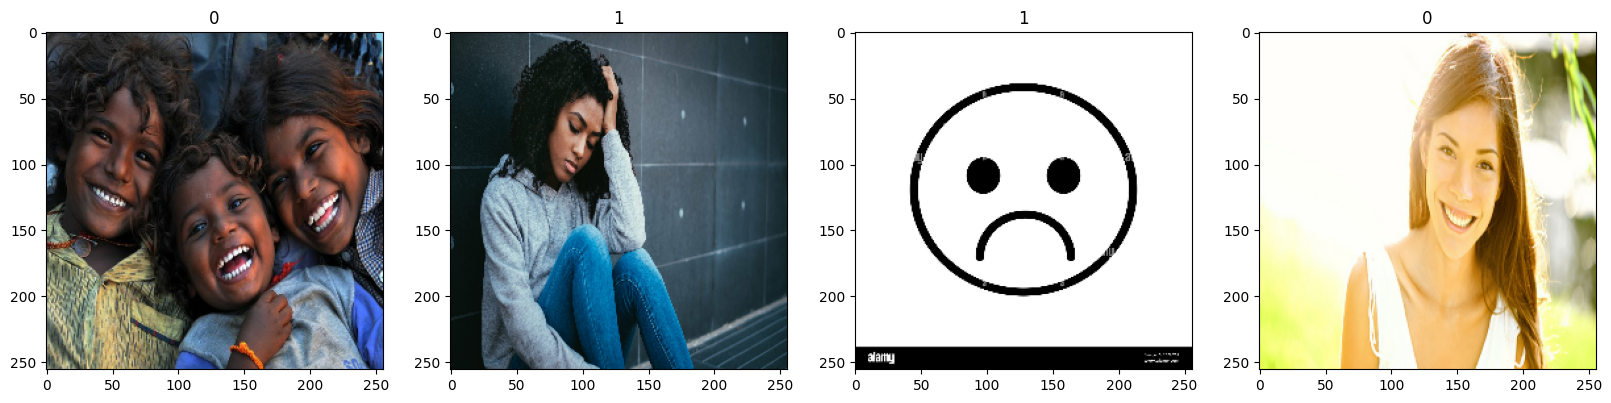

In [57]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [58]:
scaled=batch[0]/255

In [59]:
scaled.min()

0.0

#2.Preprocess Data

##2.1 Scale Data

In [60]:
data=data.map(lambda x,y:(x/255,y))
#将像素值带入适合训练机器学习模型的范围，将像素值归一化到[0,1]范围内

In [61]:
scaled_iterator=data.as_numpy_iterator()

In [62]:
batch=scaled_iterator.next()

In [63]:
batch[0].max()

1.0

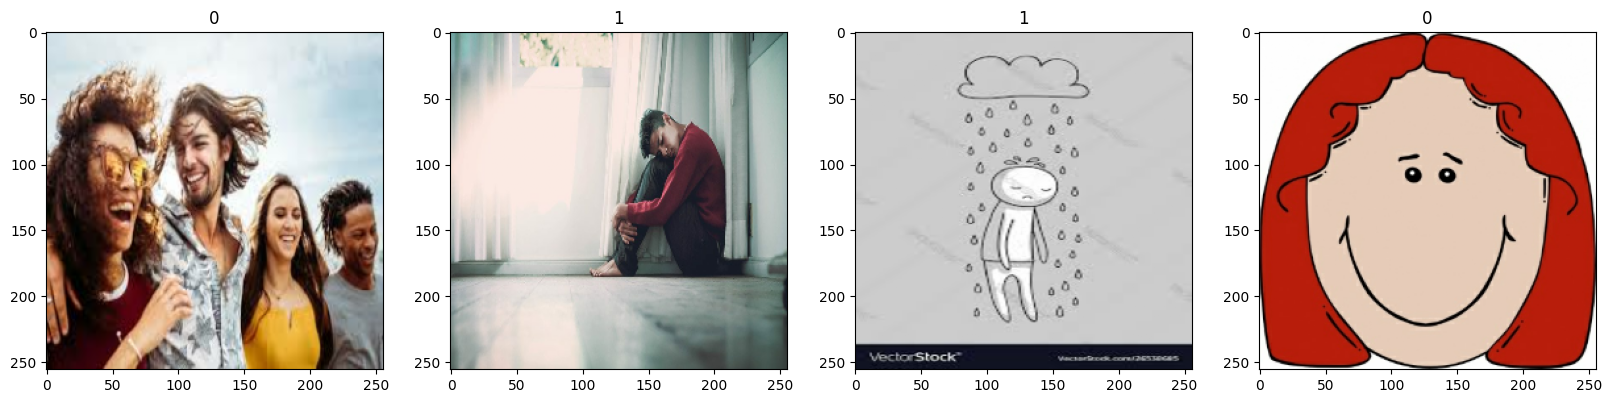

In [64]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

##2.2 Split Data

In [65]:
len(data)

15

In [79]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)
#训练集，验证集，测试集的数据分布10.4.1

In [80]:
val_size

4

In [68]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [69]:
len(test)

1

#3. Deep Learning

##3.1 Build Deep Learning Model

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [82]:
model = Sequential()

In [83]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
#这段很复杂，每一层，每个函数都需要学习

In [86]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
#这里adam根据参数的梯度大小自适应地调整学习率
#使用['accuracy']，它计算模型预测相对于真实标签的准确性。

In [85]:
model.summary()
#模型类别sequential,层级类别，每层的参数

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

##3.2 Train

In [87]:
logdir='logs'

In [88]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdir)
#如果你想回来看看你的模型是如何表现的它是否在某个特定的时间点发生变化,callback回调

In [89]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])
#fit是训练行为的组成部分，预测是我们实际去做预测的时候
#epoch是我们实际要进行训练的时间一个epoch是我们整个训练数据集的一次运行
#然后对数据进行评估，这样我们就可以实时看到我们的模型运行得有多好

Epoch 1/20
10/10 [==============================] - 39s 4s/step - loss: 0.9781 - accuracy: 0.5125 - val_loss: 0.6712 - val_accuracy: 0.5625
Epoch 2/20
10/10 [==============================] - 35s 3s/step - loss: 0.6613 - accuracy: 0.7156 - val_loss: 0.6129 - val_accuracy: 0.6328
Epoch 3/20
10/10 [==============================] - 37s 3s/step - loss: 0.6098 - accuracy: 0.6187 - val_loss: 0.5878 - val_accuracy: 0.7109
Epoch 4/20
10/10 [==============================] - 36s 3s/step - loss: 0.5428 - accuracy: 0.7906 - val_loss: 0.4913 - val_accuracy: 0.8516
Epoch 5/20
10/10 [==============================] - 35s 3s/step - loss: 0.4897 - accuracy: 0.7969 - val_loss: 0.4367 - val_accuracy: 0.8359
Epoch 6/20
10/10 [==============================] - 35s 3s/step - loss: 0.4024 - accuracy: 0.8531 - val_loss: 0.3499 - val_accuracy: 0.8750
Epoch 7/20
10/10 [==============================] - 37s 3s/step - loss: 0.3168 - accuracy: 0.8844 - val_loss: 0.2764 - val_accuracy: 0.8984
Epoch 8/20
10/10 [==

In [ ]:
hist.history

##3.3 Plot Performance

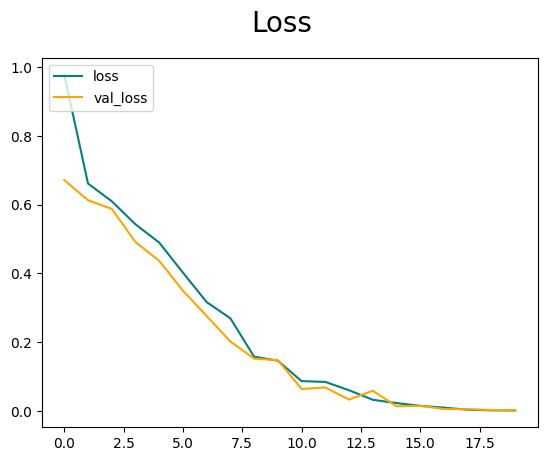

In [91]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

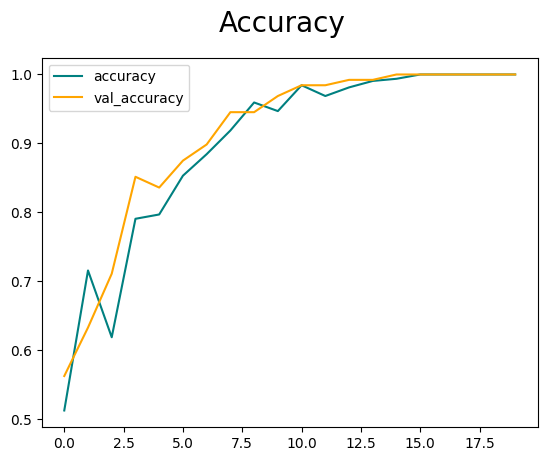

In [92]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#4. Evaluate Performance

##4.1 Evaluate

In [93]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [94]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [95]:
len(test)

1

In [96]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 328ms/step


In [97]:
print(f'Precision:{pre.result().numpy()},Recall:{re.result().numpy()} ,Accuracy:{acc.result().numpy()}')

Precision:1.0,Recall:1.0 ,Accuracy:1.0


#4.2 Test

In [98]:
import cv2

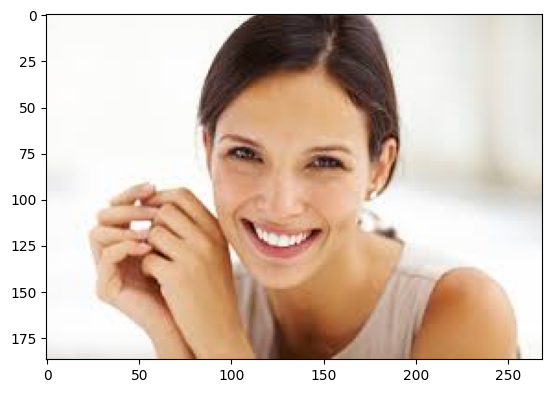

In [99]:
img = cv2.imread('/content/drive/MyDrive/AI project/Test happy/images.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
#CV2读的是BGR格式，图片呈现蓝色，需要转换为RGB格式
plt.show()

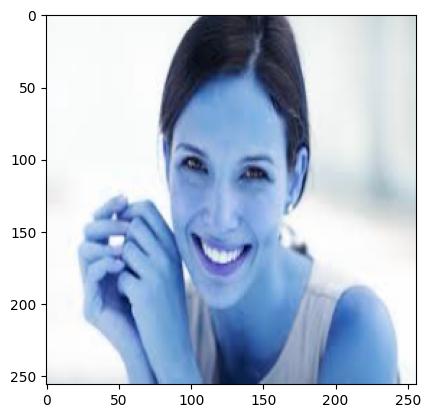

In [100]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()
#格式转换成256

In [101]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 45ms/step


In [102]:
yhat

array([[0.01741613]], dtype=float32)

In [103]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


#Save the model

## Save the Model

In [104]:
from tensorflow.keras.models import load_model

In [107]:
model.save(os.path.join('/content/drive/MyDrive/models','happysadmodel.h5'))

In [109]:
os.path.join('/content/drive/MyDrive/models','happysadmodel.h5')

'/content/drive/MyDrive/models/happysadmodel.h5'

In [110]:
new_model = load_model(os.path.join('models','happysadmodel.h5'))

In [111]:
yhatnew=new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 113ms/step


In [112]:
if yhatnew > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy
